In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.optimize import linear_sum_assignment

from utils import *

import seaborn as sns

from sklearn.metrics import silhouette_score

import warnings

warnings.filterwarnings("ignore")

from participants_utils import generate_n_spikes_using_variance, generate_spikes_using_PCA_and_variance


from sklearn.cluster import AffinityPropagation   , KMeans 


In [2]:
def gen_spikepoints(data, N=10, method="random_centroids"):
    if method == "centroids":
        centroids = KMeans(n_clusters=N).fit(data).cluster_centers_
        #centroids = AffinityPropagation().fit(data).cluster_centers_
        return centroids
    
    if method == "random":
        return generate_n_spikes_using_variance(
            dataset=data,
            variance=0.9,
            no_of_spikes=N,
        )
    
    if method == "random_centroids":
        ## concatenate both methods
        c_spikes = gen_spikepoints(data, N=N // 2, method="centroids")
        r_spikes = gen_spikepoints(data, N=N // 2, method="random")
        return np.concatenate([c_spikes, r_spikes], axis=0)
        


In [3]:
def run_pseudo_fed_eucl(data_path, n_participants=4, n_spikepoints=10,spikepoint_method="random_centroids", by_participants=True):
    """
    Run pseudo federated Euclidean clustering on the data in data_path.
    """
    data = pd.read_csv(data_path, sep="\t", index_col=0)
    # num samples, num features
    if by_participants:
        data = data.T

    data = data.to_numpy()

    real_dist_matrix = euclidean_distances(data)

    split_data = np.split(data, n_participants)

    spikepoints = [gen_spikepoints(split_data[i], N=n_spikepoints, method=spikepoint_method) for i in range(n_participants)]

    global_spikepoints = np.concatenate(spikepoints)

    lsdms = [euclidean_distances(split_data[i], global_spikepoints) for i in range(n_participants)]
    fedm = euclidean_distances(np.concatenate(lsdms))

    regs = [regression_per_client(split_data[i], lsdms[i]) for i in range(n_participants)]

    Mx, Mc = construct_global_Mx_Cx_matrix(regs)

    pedm = calc_pred_dist_matrix(
        fedm=fedm,
        global_Mx=Mx,
        global_Cx=Mc,
    )
    # done runnning, do post proccessing:


    # make real dist matrix symmetric
    real_dist_matrix = (real_dist_matrix + real_dist_matrix.T) / 2
    # make pedm symmetric
    pedm = (pedm + pedm.T) / 2
    fedm = (fedm + fedm.T) / 2


    return data, real_dist_matrix, pedm, fedm


In [4]:
def pearson_coeff(matrix1, matrix2):
    """
    Calculate the Pearson correlation coefficient between two matrices.
    """
    return np.corrcoef(matrix1.flatten(), matrix2.flatten())[0, 1]

In [5]:
def cluster_mapping(cluster1, cluster2):
    unique_clusters_1 = np.unique(cluster1)
    unique_clusters_2 = np.unique(cluster2)
    # Correct dimensions based on unique clusters
    n_clusters_1 = len(unique_clusters_1)
    n_clusters_2 = len(unique_clusters_2)
    cluster_similarity = np.zeros((n_clusters_1, n_clusters_2))
    
    for i, cluster_real in enumerate(unique_clusters_1):
        for j, cluster_predm in enumerate(unique_clusters_2):
            # Calculate the similarity for unique clusters
            shared_points_count = np.sum((cluster1 == cluster_real) & (cluster2 == cluster_predm))
            # Use negative count for 'closeness' since we're minimizing
            cluster_similarity[i, j] = -shared_points_count
    
    # Apply the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cluster_similarity)
    
    # Create and return the mapping using indices from the Hungarian algorithm output
    return {unique_clusters_1[i]: unique_clusters_2[j] for i, j in zip(row_ind, col_ind)}

# Example usage (assuming cluster1 and cluster2 are defined)
# mapping = cluster_mapping(cluster1, cluster2)


In [6]:
def plot_data_comparison(data_path, n_participants, n_clusters, n_spikepoints, spikepoint_method="random_centroids"):
    data, real_dist_matrix, pedm, fedm = run_pseudo_fed_eucl(data_path, n_participants, spikepoint_method=spikepoint_method, n_spikepoints=n_spikepoints)

    Z_real = linkage(squareform(real_dist_matrix), method='ward')
    Z_pedm = linkage(squareform(pedm), method='ward')
    Z_fedm = linkage(squareform(fedm), method='ward')
    clusters_real = fcluster(Z_real, n_clusters, criterion='maxclust')
    clusters_pedm = fcluster(Z_pedm, n_clusters, criterion='maxclust')
    clusters_fedm = fcluster(Z_fedm, n_clusters, criterion='maxclust')


    pca = PCA(n_components=2)
    data2d = pca.fit_transform(data)
    print("explained variance ratio: ", pca.explained_variance_ratio_)


    unique_clusters_real = np.unique(clusters_real)
    unique_clusters_pedm = np.unique(clusters_pedm)
    unique_clusters_fedm = np.unique(clusters_fedm)

    cluster_label_mapping_real_pedm = cluster_mapping(clusters_real, clusters_pedm)
    cluster_label_mapping_fedm_real = cluster_mapping(clusters_fedm, clusters_pedm)



    #colors = plt.colormaps['gist_ncar']
    colors = plt.cm.get_cmap('gist_ncar', n_clusters + 1)

    fig, ax = plt.subplots(ncols=3,figsize=(10, 8))

    labels_and_handles_real = []
    labels_and_handles_pedm = []
    labels_and_handles_fedm = []

    for i in unique_clusters_real:
        color = colors(cluster_label_mapping_real_pedm[i] - 1)
        cluster_size = np.sum(clusters_real == i)
        scatter = ax[0].scatter(data2d[clusters_real == i, 0], data2d[clusters_real == i, 1],color=color ,label=f"{cluster_label_mapping_real_pedm[i]}:Size: {cluster_size}", s=1)
        labels_and_handles_real.append((scatter, f"{cluster_label_mapping_real_pedm[i]}:Size: {cluster_size}"))
    for i in unique_clusters_pedm:
        color = colors(i - 1)
        cluster_size = np.sum(clusters_pedm == i)
        scatter = ax[1].scatter(data2d[clusters_pedm == i, 0], data2d[clusters_pedm == i, 1],color=color, label=f"{i}:Size: {cluster_size}", s=1)
        labels_and_handles_pedm.append((scatter, f"{i}:Size: {cluster_size}"))
    for i in unique_clusters_fedm:
        color = colors(cluster_label_mapping_fedm_real[i] - 1)
        cluster_size = np.sum(clusters_fedm == i)
        scatter = ax[2].scatter(data2d[clusters_fedm == i, 0], data2d[clusters_fedm == i, 1],color=color, label=f"{cluster_label_mapping_fedm_real[i]}:Size: {cluster_size}", s=1)
        labels_and_handles_fedm.append((scatter, f"{cluster_label_mapping_fedm_real[i]}:Size: {cluster_size}"))

    

    labels_and_handles_real.sort(key=lambda x: x[1].split(":")[0])
    labels_and_handles_pedm.sort(key=lambda x: x[1].split(":")[0])
    labels_and_handles_fedm.sort(key=lambda x: x[1].split(":")[0])

    handles_real, labels_real = zip(*labels_and_handles_real)
    handles_pedm, labels_pedm = zip(*labels_and_handles_pedm)
    handles_fedm, labels_fedm = zip(*labels_and_handles_fedm)

        
    silhouette_score_real = silhouette_score(data, clusters_real)
    silhouette_score_pedm = silhouette_score(data, clusters_pedm)
    silhouette_score_fedm = silhouette_score(data, clusters_fedm)

    ax[0].set_title(f"Real")# score: {silhouette_score_real:.5f}") # from -1 to 1
    ax[1].set_title(f"PEDM")# score: {silhouette_score_pedm:.5f}")
    ax[2].set_title(f"FEDM")# score: {silhouette_score_fedm:.5f}")


    #ax[0].legend(handles_real, labels_real)
    #ax[1].legend(handles_pedm, labels_pedm)
    #ax[2].legend(handles_fedm, labels_fedm)

    plt.show()

# TODO: b-data & dbscan clustering / hdbscan clustering
# sklearn website -> find right clustering

explained variance ratio:  [0.06179287 0.03969072]


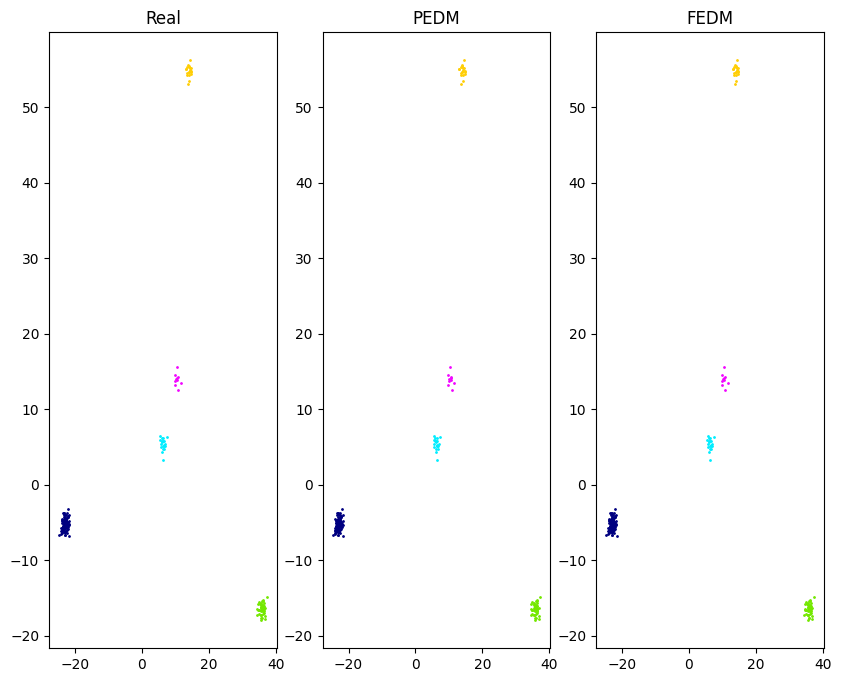

In [8]:
plot_data_comparison(
    "./simulatedData/simulated/A/A.n_genes=500,m=4,std=1,overlap=no.exprs_z.tsv",
    4,
    5,
    10,
    spikepoint_method="random_centroids"
)

explained variance ratio:  [0.04145953 0.03673731]


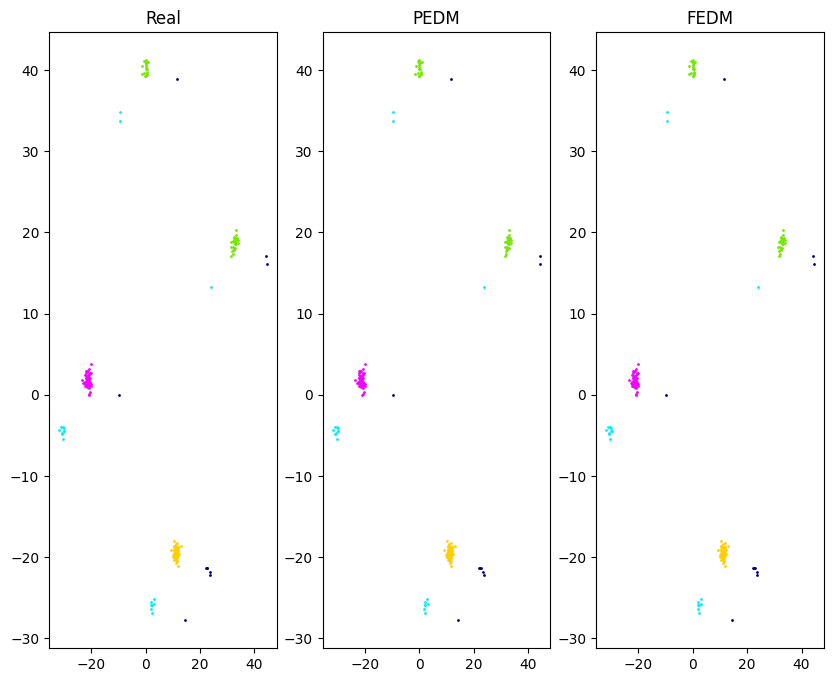

In [9]:
plot_data_comparison(
    "./simulatedData/simulated/B/B.n_genes=500,m=4,std=1,overlap=yes.exprs_z.tsv",
    4,
    5,
    10,
    spikepoint_method="random_centroids"
)

explained variance ratio:  [0.04153474 0.0368874 ]


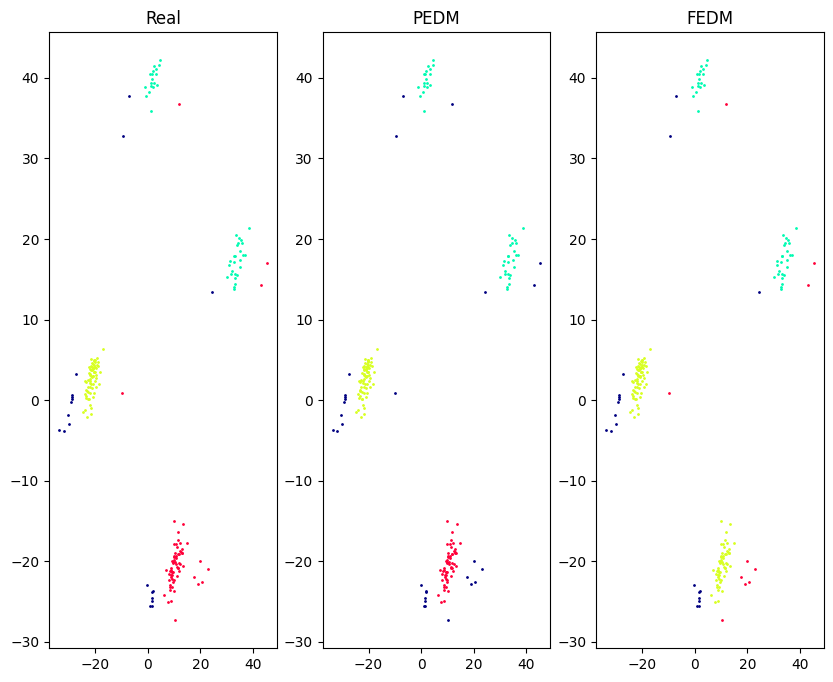

In [10]:
plot_data_comparison(
    "./simulatedData/simulated/C/C.n_genes=500,m=4,std=1,overlap=yes.exprs_z.tsv",
    4,
    4,
    20,
    spikepoint_method="random_centroids"
)

explained variance ratio:  [0.00623466 0.0061959 ]


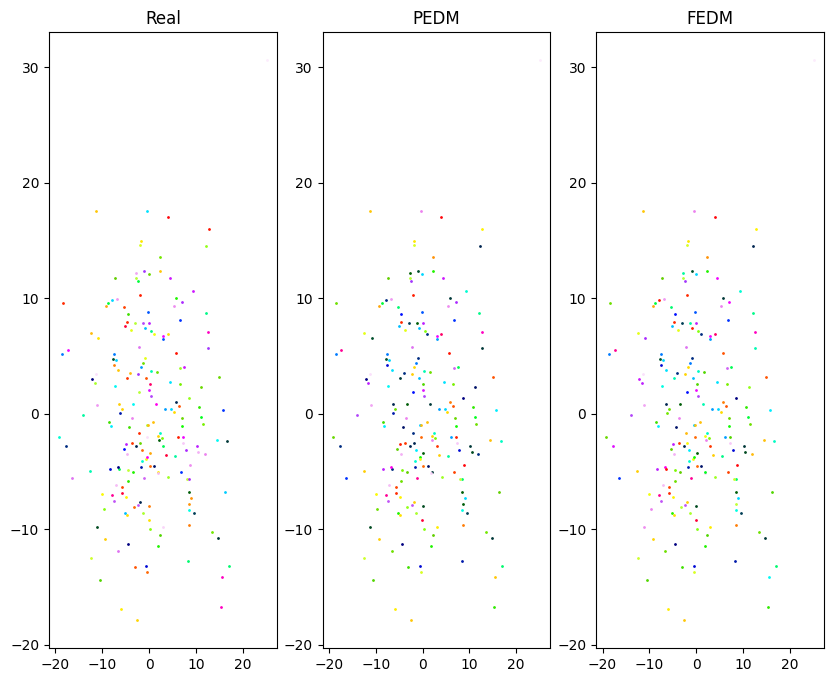

In [11]:
plot_data_comparison(
    "./simulatedData/simulated/A/A.n_genes=5,m=4,std=1,overlap=no.exprs_z.tsv",
    4,
    100,
    20,
    spikepoint_method="random_centroids"
)

In [9]:
from tqdm import tqdm

def analysis_table(
        data_path,
        n_paticipants_list =[2, 4, 10, 20],
        n_spikes_list = [2, 3, 5, 10],
        methdos_list = ["centroids", "random", "random_centroids"]
):
    
    results = []

    for n_participants in tqdm(n_paticipants_list):
        for n_spikes in n_spikes_list:
            total_spikes = n_participants * n_spikes

            if total_spikes >= 200:
                continue
            for method in methdos_list:
                try:
                    _, real_dist_matrix, pedm, fedm = run_pseudo_fed_eucl(data_path, n_participants, n_spikes, spikepoint_method=method)
                    pred_cerf = pearson_coeff(real_dist_matrix, pedm)
                    fedm_coeff = pearson_coeff(real_dist_matrix, fedm)
                except Exception as e:
                    print(e)
                    pred_cerf = None
                    fedm_coeff = None

                
                results.append(
                    {
                        "method": method,
                        "n_participants": n_participants,
                        "n_spikes": n_spikes,
                        "total_spikes": total_spikes,
                        "pedm_coeff": pred_cerf,
                        "fedm_coeff": fedm_coeff,
                    }
                )
                #print(f"Method: {method} Participants: {n_participants}, Spikes: {n_spikes}, Pearson: {pred_cerf}, FEDM: {fedm_coeff}")
    return pd.DataFrame(results)

def colored_table(df):
    # Pivoting to get 'method' as part of the column headers
    df_pivot = df.pivot_table(index=['n_participants', 'total_spikes'],
                              columns='method',
                              values=['pedm_coeff', 'fedm_coeff'],
                              aggfunc='mean')  # Assuming you want to aggregate by mean if there are duplicates
    

    # Rearrange the columns to have a MultiIndex with method as the first level and coeff types as the second level
    df_pivot.columns = pd.MultiIndex.from_tuples([(x[1], x[0]) for x in df_pivot.columns])

    # Sort the MultiIndex for better organization (optional)
    df_pivot.sort_index(axis=1, level=0, inplace=True)


    fedm_cmap = sns.light_palette("green", as_cmap=True)
    pedm_cmap = sns.light_palette("blue", as_cmap=True)

    # Assuming df_pivot is your pivot table after aggregation
    styled_df = df_pivot.style.background_gradient(cmap=fedm_cmap, subset=pd.IndexSlice[:, pd.IndexSlice[:, 'fedm_coeff']], vmin=0.1, vmax=0.8) \
                          .background_gradient(cmap=pedm_cmap, subset=pd.IndexSlice[:, pd.IndexSlice[:, 'pedm_coeff']], vmin=0.8, vmax=1.)
    return styled_df

# presentation

## datasets that portray more visible clusters -> higher coefficiants

For a dataset which por- trays more visible clusters or have multiple high-density regions comprised of the value of the data points, centroids as the spike points will provide more strongly correlated

### highly visible clusters

In [28]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=500,m=4,std=1,overlap=no.exprs_z.tsv",
    n_paticipants_list =[4],
    n_spikes_list = [2, 3, 5],
)
colored_table(res_df)

100%|██████████| 1/1 [00:15<00:00, 15.80s/it]


explained variance ratio:  [0.06179287 0.03969072]


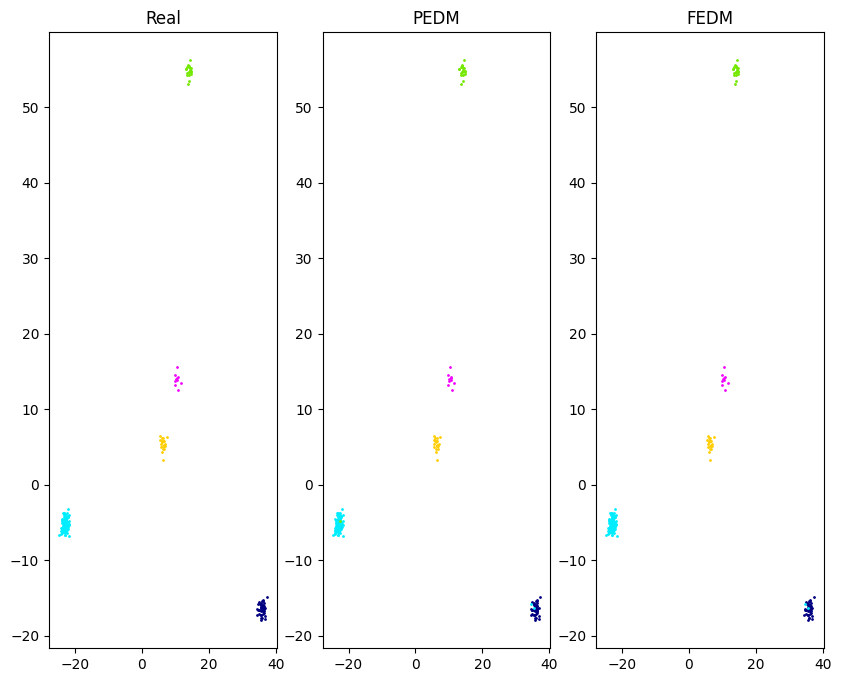

In [24]:
plot_data_comparison(
    "./simulatedData/simulated/A/A.n_genes=500,m=4,std=1,overlap=no.exprs_z.tsv",
    4,
    5,
    5,
    spikepoint_method="random"
)

### not so visible clusters

In [39]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=50,m=4,std=1,overlap=no.exprs_z.tsv",
    n_paticipants_list =[4],
    n_spikes_list = [2, 3, 5],
)
colored_table(res_df)

100%|██████████| 1/1 [00:15<00:00, 15.99s/it]


explained variance ratio:  [0.01069665 0.00853196]


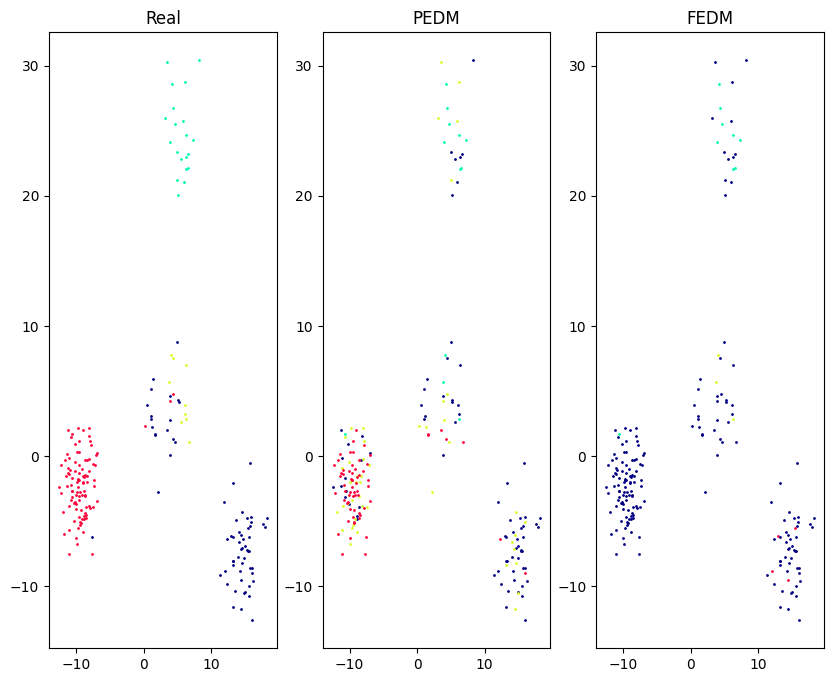

In [45]:
plot_data_comparison(
    "./simulatedData/simulated/A/A.n_genes=50,m=4,std=1,overlap=no.exprs_z.tsv",
    4,
    4,
    5,
    spikepoint_method="centroids"
)

## if data is normally distributed, the centroids work better

If the data consists of isotropic gaussian blobs where all data points belong to one of the cluster and all cluster have the same standard deviation, more information is gained from spike points which are centroid-based [62].

In [30]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=500,m=4,std=1,overlap=no.exprs_z.tsv",
    n_paticipants_list =[4],
    n_spikes_list = [2, 3, 5],
    methdos_list=["centroids", "random"]
)
colored_table(res_df)

100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


In [31]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=5,m=4,std=1,overlap=no.exprs_z.tsv",
    n_paticipants_list =[4],
    n_spikes_list = [2, 3, 5],
    methdos_list=["centroids", "random"]
)
colored_table(res_df)

100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


## More spikepoints == better?

Not really

In [36]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=500,m=4,std=1,overlap=no.exprs_z.tsv",
    n_paticipants_list =[4],
    n_spikes_list = [2, 3, 5, 10, 20, 30, 40],
)
colored_table(res_df)

100%|██████████| 1/1 [00:48<00:00, 48.61s/it]


## Clustering harder data?

explained variance ratio:  [0.01070332 0.00849633]


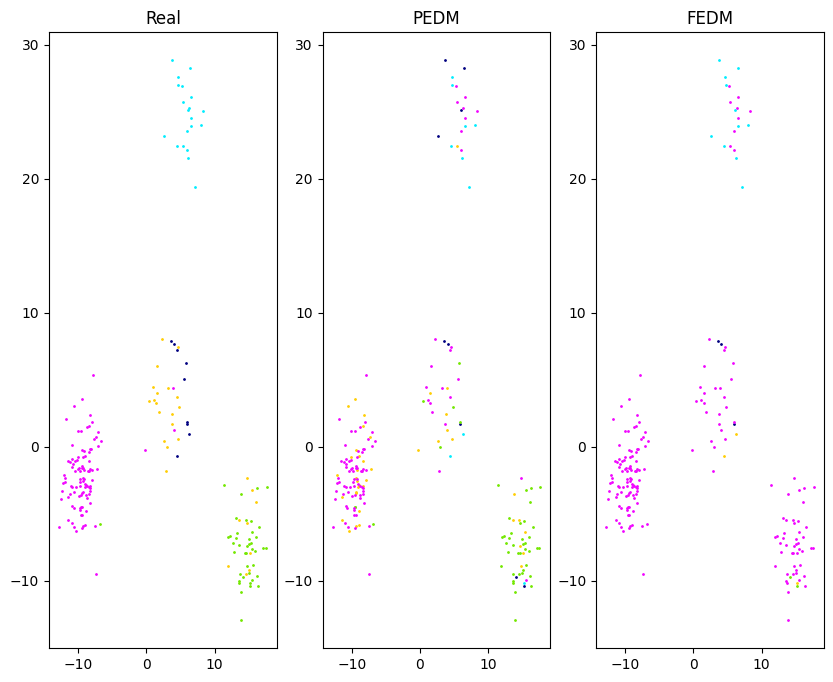

In [35]:
plot_data_comparison(
    "./simulatedData/simulated/A/A.n_genes=50,m=4,std=1,overlap=no.exprs_z.tsv",
    4,
    5,
    5,
    spikepoint_method="centroids"
)

## Works great overall

 how FEDM can be far away from ADM but performing regression can almost reconstruct a distance matrix (PEDM) having more than 80% similarity and did not expect there will be drastic variance between Pearson and Spearman correlation coefficient values


In [33]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=500,m=4,std=1,overlap=no.exprs_z.tsv",
)
colored_table(res_df)

100%|██████████| 4/4 [01:52<00:00, 28.11s/it]


In [46]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=50,m=4,std=1,overlap=no.exprs_z.tsv",
)
colored_table(res_df)

100%|██████████| 4/4 [01:57<00:00, 29.35s/it]


## Latex

In [7]:
# Assuming the rest of your code is unchanged and just modifying the colored_table function

def latex_table(df):
    # Pivoting to get 'method' as part of the column headers
    df_pivot = df.pivot_table(index=['n_participants', 'total_spikes'],
                              columns='method',
                              values=['pedm_coeff', 'fedm_coeff'],
                              aggfunc='mean')  # Assuming you want to aggregate by mean if there are duplicates

    # Rearrange the columns to have a MultiIndex with method as the first level and coeff types as the second level
    df_pivot.columns = pd.MultiIndex.from_tuples([(x[1], x[0]) for x in df_pivot.columns])

    # Sort the MultiIndex for better organization (optional)
    df_pivot.sort_index(axis=1, level=0, inplace=True)

    # Convert the DataFrame to a LaTeX table string
    latex_str = df_pivot.to_latex(index=True, multirow=True, multicolumn=True, header=True, column_format='l' + 'c' * df_pivot.columns.size)

    return latex_str


In [10]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=50,m=4,std=1,overlap=no.exprs_z.tsv",
)
print(latex_table(res_df))

100%|██████████| 4/4 [02:00<00:00, 30.08s/it]

\begin{tabular}{lcccccc}
\toprule
 &  & \multicolumn{2}{r}{centroids} & \multicolumn{2}{r}{random} & \multicolumn{2}{r}{random_centroids} \\
 &  & fedm_coeff & pedm_coeff & fedm_coeff & pedm_coeff & fedm_coeff & pedm_coeff \\
n_participants & total_spikes &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{2} & 4 & 0.175609 & 0.993300 & 0.160042 & 0.992795 & 0.125287 & 0.992800 \\
 & 6 & 0.188583 & 0.993352 & 0.213903 & 0.992816 & 0.107937 & 0.992769 \\
 & 10 & 0.135457 & 0.993870 & 0.269048 & 0.992884 & 0.165725 & 0.992774 \\
 & 20 & 0.144386 & 0.993620 & 0.359764 & 0.992892 & 0.276973 & 0.992989 \\
\cline{1-8}
\multirow[t]{4}{*}{4} & 8 & 0.114405 & 0.992858 & 0.183577 & 0.992884 & 0.138334 & 0.992847 \\
 & 12 & 0.225582 & 0.993310 & 0.213557 & 0.992855 & 0.140081 & 0.992842 \\
 & 20 & 0.183959 & 0.993488 & 0.276808 & 0.992887 & 0.204031 & 0.993206 \\
 & 40 & 0.137930 & 0.992777 & 0.386652 & 0.993111 & 0.324291 & 0.993366 \\
\cline{1-8}
\multirow[t]{4}{*}{10} & 20 & 0.144145 & 0.992956 &

In [11]:
res_df = analysis_table(
    "./simulatedData/simulated/A/A.n_genes=500,m=4,std=1,overlap=no.exprs_z.tsv",
)
print(latex_table(res_df))

100%|██████████| 4/4 [01:49<00:00, 27.40s/it]

\begin{tabular}{lcccccc}
\toprule
 &  & \multicolumn{2}{r}{centroids} & \multicolumn{2}{r}{random} & \multicolumn{2}{r}{random_centroids} \\
 &  & fedm_coeff & pedm_coeff & fedm_coeff & pedm_coeff & fedm_coeff & pedm_coeff \\
n_participants & total_spikes &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{2} & 4 & 0.627594 & 0.967860 & 0.375260 & 0.838678 & 0.480775 & 0.888849 \\
 & 6 & 0.655023 & 0.982886 & 0.526907 & 0.888359 & 0.494855 & 0.890646 \\
 & 10 & 0.659617 & 0.987809 & 0.532973 & 0.893782 & 0.602860 & 0.932886 \\
 & 20 & 0.661632 & 0.982739 & 0.620551 & 0.911685 & 0.681406 & 0.976132 \\
\cline{1-8}
\multirow[t]{4}{*}{4} & 8 & 0.657349 & 0.983093 & 0.390539 & 0.838108 & 0.563686 & 0.921780 \\
 & 12 & 0.657724 & 0.983138 & 0.495382 & 0.874867 & 0.557903 & 0.917471 \\
 & 20 & 0.662551 & 0.987505 & 0.541905 & 0.889171 & 0.659275 & 0.966186 \\
 & 40 & 0.631353 & 0.964155 & 0.581825 & 0.898330 & 0.683359 & 0.976917 \\
\cline{1-8}
\multirow[t]{4}{*}{10} & 20 & 0.665947 & 0.983990 &